In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import h5py
import json
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# Specify location of data
folder = 'LOSC_Event_tutorial/'
plt.style.use('seaborn-muted')

# READ IN DATA

In [2]:
def read_template(filename):
    dataFile = h5py.File(filename,'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    dataFile.close()
    return strain, dt, utc

In [31]:
file_names = os.listdir(folder)

# Save events from Hanford, Livingston and corresponding GW template
L_events = []
H_events = []
for file in file_names: 
    if file[0] == 'H':
        H_events.append(file)
        for j in file_names: 
            if j[:] == 'L-L1_LOSC_4' + file[11:]:
                L_events.append(j)

# Save GW templates manually, making sure it corresponds to correct event
GW = ['GW170104_4_template.hdf5','GW151226_4_template.hdf5','LVT151012_4_template.hdf5','GW150914_4_template.hdf5']

In [34]:
print('''
Handford Events:
-----------------
{0}

Livinston Events:
-----------------
{1}

GW Templates:
-----------------
{2}
'''.format(H_events, L_events, GW))


Handford Events:
-----------------
['H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1126259446-32.hdf5']

Livinston Events:
-----------------
['L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1126259446-32.hdf5']

GW Templates:
-----------------
['GW170104_4_template.hdf5', 'GW151226_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW150914_4_template.hdf5']



# PART A: ESTIMATING NOISE MODEL

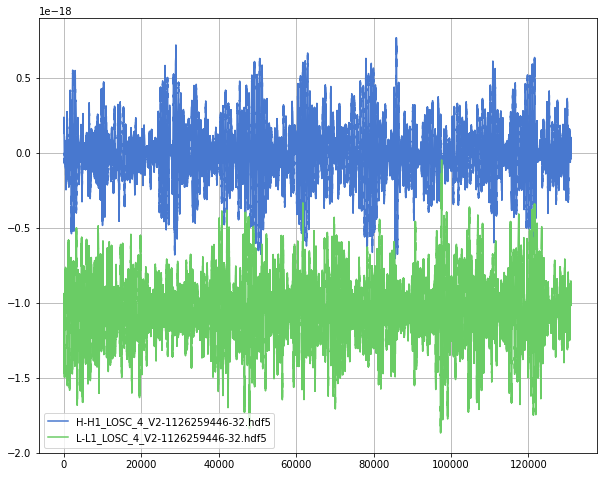

In [42]:
# Let's run through an example, choosing the last event. 
index = -1
strain_H1, dt, utc_H1 = read_file(folder + H_events[index])
strain_L1, dt, utc_L1 = read_file(folder + L_events[index])
th, tl = read_template(folder + GW[index])

# Plot strain
plt.figure(figsize=(10,8))
plt.plot(strain_H1, label = H_events[index])
plt.plot(strain_L1, label = L_events[index])
plt.legend()
plt.grid()
plt.show()


In [39]:
# First, we need to get a sense of what the noise looks like. 
# To do this, let's plot the Amplitude Spectral Densities. 
# ASD is the square root of PSD, where PSD is the average of the square of the FFT of the strain.

def get_asd(strain, fs = 4096 , NFFT = 4*4096, interp = False):
    
    psd, freqs = mlab.psd(strain, Fs = fs, NFFT = NFFT)
    
    asd = np.sqrt(psd)
    
    
    if interp:
        # Return interpolation of psd
        psd_interp = interp1d(freqs, psd)
        
        return asd, freqs, psd_interp
    
    return asd, freqs

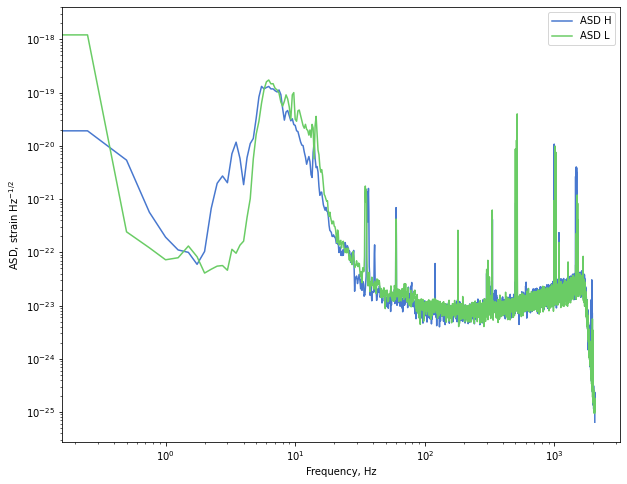

In [41]:
# Get ASD of H1 and L1
asd_H1, freqs = get_asd(strain_H1)
asd_L1, freqs = get_asd(strain_L1)

# Plot
plt.figure(figsize=(10,8))
plt.loglog(freqs, asd_H1, label = 'ASD H')
plt.loglog(freqs, asd_L1, label = 'ASD L')
plt.xlabel('Frequency, Hz')
plt.ylabel('ASD, strain Hz$^{-1/2}$')
plt.legend()
plt.show()

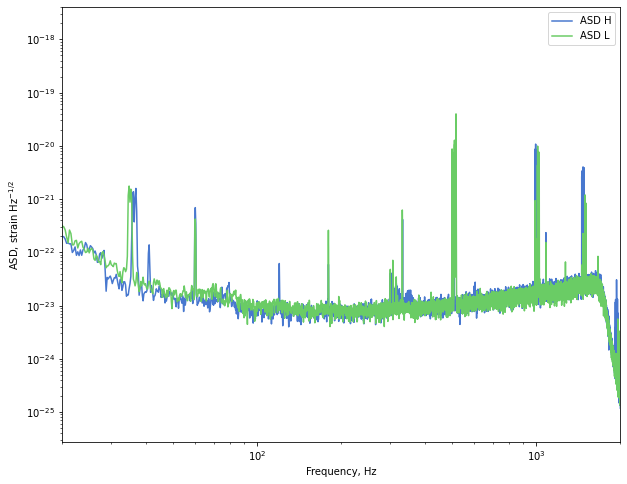

In [43]:
# The data we care about lies in the frequency range of 20 Hz to 2000 Hz. Data is not properly calibrated below 20 Hz 
# and if we go above the Nyquist frequency = fs/2, we cannot capture the data. The plot below takes into account these
# ranges.
fmin = 20
fmax = 2000

plt.figure(figsize=(10,8))
plt.loglog(freqs, asd_H1, label = 'ASD H')
plt.loglog(freqs, asd_L1, label = 'ASD L')
plt.xlabel('Frequency, Hz')
plt.ylabel('ASD, strain Hz$^{-1/2}$')
plt.xlim(fmin, fmax)
plt.legend()
plt.show()

In [44]:
# The goal is to remove all of the signal coming from instrumental noise so that we can pick out the actual GW. 
# First, let's define some window functions
def window(n):
    x = np.linspace(-np.pi, np.pi, n)
    return 0.5 + 0.5*np.cos(x)

def make_flat_window(n,m):
    tmp = window(m)
    win = np.ones(n)
    mm = m//2
    win[:mm] = tmp[:mm]
    win[-mm:] = tmp[-mm: ]
    return win

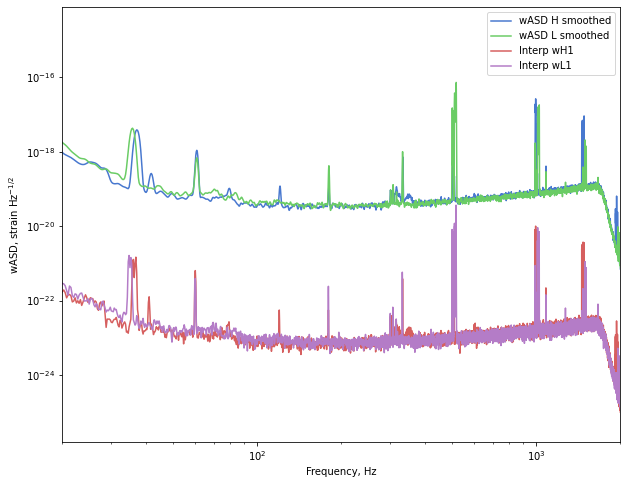

In [53]:
# Plot windowed results
N = len(strain_H1)
wind = make_flat_window(N, N//5)
ws_H1 = wind*strain_H1
ws_L1 = wind*strain_L1




# Get windowed asd
ws_asd_H1, freqs, interp_H1 = get_asd(ws_H1, interp = True)
ws_asd_L1, freqs, interp_L1 = get_asd(ws_L1, interp = True)

ps_asd_H1 = ws_asd_H1**2
ps_asd_L1 = ws_asd
# Smooth out asd
for i in range(10):
    ws_asd_H1 = ws_asd_H1 + np.roll(ws_asd_H1, 1) + np.roll(ws_asd_H1, -1)/3
    ws_asd_L1 = ws_asd_L1 + np.roll(ws_asd_L1, 1) + np.roll(ws_asd_L1, -1)/3

# Plot
fmin = 20
fmax = 2000

plt.figure(figsize=(10,8))
plt.loglog(freqs, ws_asd_H1, label = 'wASD H smoothed')
plt.loglog(freqs, ws_asd_L1, label = 'wASD L smoothed')
plt.loglog(freqs, np.sqrt(interp_H1(freqs)), label = 'Interp wH1')
plt.loglog(freqs, np.sqrt(interp_L1(freqs)), label = 'Interp wL1')
plt.xlabel('Frequency, Hz')
plt.ylabel('wASD, strain Hz$^{-1/2}$')
plt.xlim(fmin, fmax)
plt.legend()
plt.show()


In [ ]:
# Now, let's window and whiten the data

def whiten_data(strain):
    
    N = len(strain)
    
    # Get window function
    wind = make_flat_window(N,N//5)
    
    # Get Fourier transform of window*strain
    strain_ft = np.fft.rfft(wind*strain)
    
    
    


In [47]:
N = len(strain_H1)
wind = make_flat_window(N, N//5)
wind_strain = wind*strain_H1

winstrain_asd, freqs, interp = get_asd(wind_strain, interp = True)

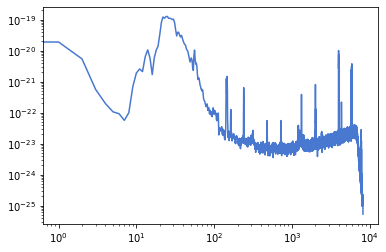

In [48]:
plt.loglog(winstrain_asd)
plt.show()